<a href="https://colab.research.google.com/github/jorobledo/bayesian_statistical_learning_2/blob/main/BLcourse2.3/colab/02_two_dim_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About

In this notebook, we use a GP to fit a 2D data set. We use the same ExactGP
machinery as in the 1D case and show how GPs can be used for 2D interpolation
(when data is free of noise) or regression (noisy data). Think of this as a
toy geospatial data setting. Actually, in geostatistics, Gaussian process
regression is known as [Kriging](https://en.wikipedia.org/wiki/Kriging).
$\newcommand{\ve}[1]{\mathit{\boldsymbol{#1}}}$
$\newcommand{\ma}[1]{\mathbf{#1}}$
$\newcommand{\pred}[1]{\rm{#1}}$
$\newcommand{\predve}[1]{\mathbf{#1}}$
$\newcommand{\test}[1]{#1_*}$
$\newcommand{\testtest}[1]{#1_{**}}$
$\DeclareMathOperator{\diag}{diag}$
$\DeclareMathOperator{\cov}{cov}$

In [2]:
##%matplotlib notebook
# %matplotlib widget
%matplotlib inline

!pip install -q gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!wget -q https://raw.githubusercontent.com/jorobledo/bayesian_statistical_learning_2/refs/heads/main/BLcourse2.3/utils.py

In [4]:
from collections import defaultdict
from pprint import pprint

import torch
import gpytorch
from matplotlib import pyplot as plt
from matplotlib import is_interactive
import numpy as np

from sklearn.preprocessing import StandardScaler

from utils import extract_model_params, fig_ax_3d

In [5]:
torch.set_default_dtype(torch.float64)
torch.manual_seed(123)

# Generate toy 2D data

Our ground truth function is $f(\ve x) = \sin(r) / r$ with $\ve x =
[x_0,x_1] \in\mathbb R^2$ and the radial distance
$r=\sqrt{\ve x^\top\,\ve x}$, also known as "Mexican hat" function, which is a
radial wave-like pattern which decays with distance from the center $\ve
x=\ve 0$. We generate data by random sampling 2D points $\ve x_i$ and calculating
$y_i = f(\ve x_i)$, optionally adding Gaussian noise further down.

In [6]:
class MexicanHat:
    def __init__(self, xlim, ylim, nx, ny, mode, **kwds):
        self.xlim = xlim
        self.ylim = ylim
        self.nx = nx
        self.ny = ny
        self.xg, self.yg = self._get_xy_grid()
        self.XG, self.YG = self._get_meshgrids(self.xg, self.yg)
        self.X = self._make_X(mode)
        self.z = self.func(self.X)

    def _make_X(self, mode="grid"):
        if mode == "grid":
            X = torch.empty((self.nx * self.ny, 2))
            X[:, 0] = self.XG.flatten()
            X[:, 1] = self.YG.flatten()
        elif mode == "rand":
            X = torch.rand(self.nx * self.ny, 2)
            X[:, 0] = X[:, 0] * (self.xlim[1] - self.xlim[0]) + self.xlim[0]
            X[:, 1] = X[:, 1] * (self.ylim[1] - self.ylim[0]) + self.ylim[0]
        return X

    def _get_xy_grid(self):
        x = torch.linspace(self.xlim[0], self.xlim[1], self.nx)
        y = torch.linspace(self.ylim[0], self.ylim[1], self.ny)
        return x, y

    @staticmethod
    def _get_meshgrids(xg, yg):
        return torch.meshgrid(xg, yg, indexing="ij")

    @staticmethod
    def func(X):
        r = torch.sqrt((X**2).sum(axis=1))
        return torch.sin(r) / r

    @staticmethod
    def n2t(x):
        return torch.from_numpy(x)

    def apply_scalers(self, x_scaler, y_scaler):
        self.X = self.n2t(x_scaler.transform(self.X))
        Xtmp = x_scaler.transform(torch.stack((self.xg, self.yg), dim=1))
        self.XG, self.YG = self._get_meshgrids(
            self.n2t(Xtmp[:, 0]), self.n2t(Xtmp[:, 1])
        )
        self.z = self.n2t(y_scaler.transform(self.z[:, None])[:, 0])

In [7]:
data_train = MexicanHat(
    xlim=[-15, 25], ylim=[-15, 5], nx=20, ny=20, mode="rand"
)
x_scaler = StandardScaler().fit(data_train.X)
y_scaler = StandardScaler().fit(data_train.z[:, None])
data_train.apply_scalers(x_scaler, y_scaler)

data_pred = MexicanHat(
    xlim=[-15, 25], ylim=[-15, 5], nx=100, ny=100, mode="grid"
)
data_pred.apply_scalers(x_scaler, y_scaler)

# train inputs
X_train = data_train.X

# inputs for prediction and plotting
X_pred = data_pred.X

# Exercise 1

Keep the settings below and explore the notebook till the end first.

In [8]:
use_noise = False
use_gap = False

# Exercise 2

First complete the notebook as is, then come back here.

In [9]:
##use_noise = False
##use_gap = True

# Exercise 3

First complete the notebook with Exercise 2, then come back here.

In [10]:
##use_noise = True
##use_gap = True

In [11]:
if use_noise:
    # noisy train data
    noise_std = 0.2
    noise_dist = torch.distributions.Normal(loc=0, scale=noise_std)
    y_train = data_train.z + noise_dist.sample(
        sample_shape=(len(data_train.z),)
    )
else:
    # noise-free train data
    noise_std = 0
    y_train = data_train.z

In [12]:
# Cut out part of the train data to create out-of-distribution predictions.
# Same as the "gaps" we created in the 1D case.

if use_gap:
    mask = (X_train[:, 0] > 0) & (X_train[:, 1] < 0)
    X_train = X_train[~mask, :]
    y_train = y_train[~mask]

Text(0.5, 0.5, 'X_1')

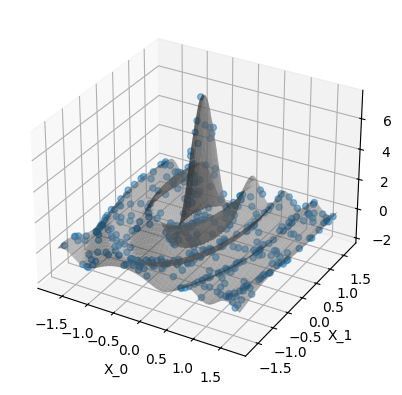

In [13]:
fig, ax = fig_ax_3d()
s0 = ax.plot_surface(
    data_pred.XG,
    data_pred.YG,
    data_pred.z.reshape((data_pred.nx, data_pred.ny)),
    color="tab:grey",
    alpha=0.5,
)
s1 = ax.scatter(
    xs=X_train[:, 0],
    ys=X_train[:, 1],
    zs=y_train,
    color="tab:blue",
    alpha=0.5,
)
ax.set_xlabel("X_0")
ax.set_ylabel("X_1")

The gray surface is the ground truth function. The blue points are the
training data.

# Define GP model

In [14]:
class ExactGPModel(gpytorch.models.ExactGP):
    """API:

    model.forward()             prior                   f_pred
    model()                     posterior               f_pred

    likelihood(model.forward()) prior with noise        y_pred
    likelihood(model())         posterior with noise    y_pred
    """

    def __init__(self, X_train, y_train, likelihood):
        super().__init__(X_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        """The prior, defined in terms of the mean and covariance function."""
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

In [15]:
# Inspect the model
print(model)

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)


In [16]:
# Default start hyper params
pprint(extract_model_params(model))

{'covar_module.base_kernel.lengthscale': tensor([[0.6931]], grad_fn=<SoftplusBackward0>),
 'covar_module.outputscale': tensor(0.6931, grad_fn=<SoftplusBackward0>),
 'likelihood.noise_covar.noise': tensor([0.6932], grad_fn=<AddBackward0>),
 'mean_module.constant': Parameter containing:
tensor(0., requires_grad=True)}


In [17]:
# Set new start hyper params
model.mean_module.constant = 0.0
model.covar_module.base_kernel.lengthscale = 3.0
model.covar_module.outputscale = 8.0
model.likelihood.noise_covar.noise = 0.1

pprint(extract_model_params(model))

{'covar_module.base_kernel.lengthscale': tensor([[3.]], grad_fn=<SoftplusBackward0>),
 'covar_module.outputscale': tensor(8., grad_fn=<SoftplusBackward0>),
 'likelihood.noise_covar.noise': tensor([0.1000], grad_fn=<AddBackward0>),
 'mean_module.constant': Parameter containing:
tensor(0., requires_grad=True)}


# Fit GP to data: optimize hyper params

In [18]:
# Train mode
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.15)
loss_func = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 400
history = defaultdict(list)
for ii in range(n_iter):
    optimizer.zero_grad()
    loss = -loss_func(model(X_train), y_train)
    loss.backward()
    optimizer.step()
    if (ii + 1) % 10 == 0:
        print(f"iter {ii + 1}/{n_iter}, {loss=:.3f}")
    for p_name, p_val in extract_model_params(model, try_item=True).items():
        history[p_name].append(p_val)
    history["loss"].append(loss.item())

iter 10/400, loss=1.835
iter 20/400, loss=1.356
iter 30/400, loss=1.340
iter 40/400, loss=1.294
iter 50/400, loss=1.223
iter 60/400, loss=1.124
iter 70/400, loss=0.986
iter 80/400, loss=0.843
iter 90/400, loss=0.723
iter 100/400, loss=0.594
iter 110/400, loss=0.458
iter 120/400, loss=0.323
iter 130/400, loss=0.190
iter 140/400, loss=0.061
iter 150/400, loss=-0.062
iter 160/400, loss=-0.178
iter 170/400, loss=-0.286
iter 180/400, loss=-0.385
iter 190/400, loss=-0.475
iter 200/400, loss=-0.553
iter 210/400, loss=-0.606
iter 220/400, loss=-0.672
iter 230/400, loss=-0.710
iter 240/400, loss=-0.745
iter 250/400, loss=-0.770
iter 260/400, loss=-0.788
iter 270/400, loss=-0.801
iter 280/400, loss=-0.811
iter 290/400, loss=-0.819
iter 300/400, loss=-0.825
iter 310/400, loss=-0.830
iter 320/400, loss=-0.834
iter 330/400, loss=-0.837
iter 340/400, loss=-0.840
iter 350/400, loss=-0.842
iter 360/400, loss=-0.844
iter 370/400, loss=-0.846
iter 380/400, loss=-0.847
iter 390/400, loss=-0.849
iter 400/

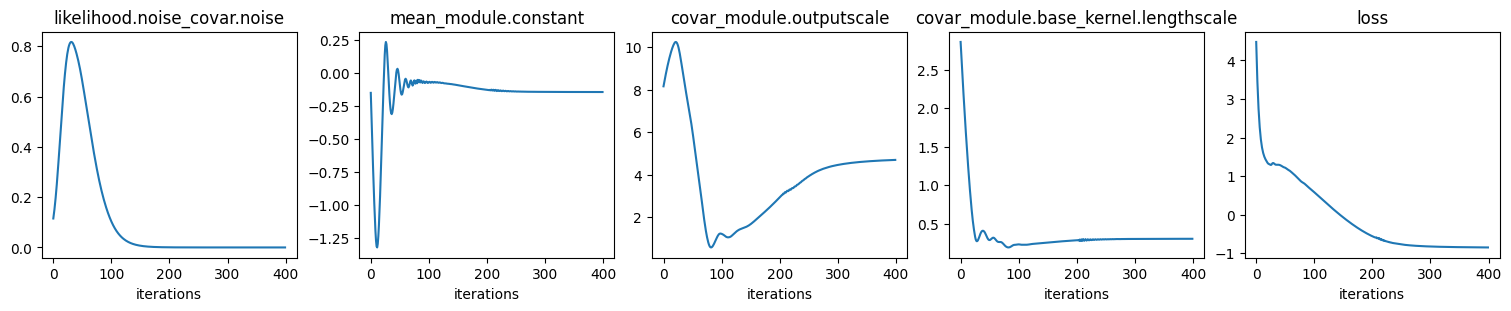

In [19]:
ncols = len(history)
fig, axs = plt.subplots(
    ncols=ncols, nrows=1, figsize=(ncols * 3, 3), layout="compressed"
)
with torch.no_grad():
    for ax, (p_name, p_lst) in zip(axs, history.items()):
        ax.plot(p_lst)
        ax.set_title(p_name)
        ax.set_xlabel("iterations")

In [20]:
# Values of optimized hyper params
pprint(extract_model_params(model))

{'covar_module.base_kernel.lengthscale': tensor([[0.3063]], grad_fn=<SoftplusBackward0>),
 'covar_module.outputscale': tensor(4.6931, grad_fn=<SoftplusBackward0>),
 'likelihood.noise_covar.noise': tensor([0.0001], grad_fn=<AddBackward0>),
 'mean_module.constant': Parameter containing:
tensor(-0.1436, requires_grad=True)}


# Run prediction

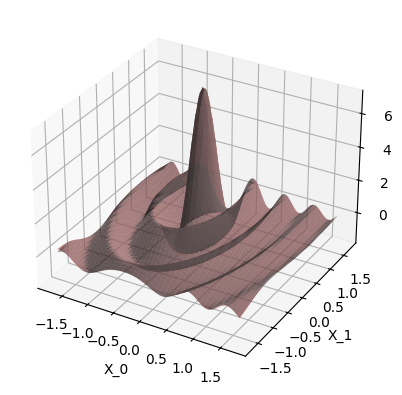

In [21]:
model.eval()
likelihood.eval()

with torch.no_grad():
    post_pred_f = model(X_pred)
    post_pred_y = likelihood(model(X_pred))

    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    ax.plot_surface(
        data_pred.XG,
        data_pred.YG,
        data_pred.z.reshape((data_pred.nx, data_pred.ny)),
        color="tab:grey",
        alpha=0.5,
    )
    ax.plot_surface(
        data_pred.XG,
        data_pred.YG,
        post_pred_y.mean.reshape((data_pred.nx, data_pred.ny)),
        color="tab:red",
        alpha=0.5,
    )
    ax.set_xlabel("X_0")
    ax.set_ylabel("X_1")

assert (post_pred_f.mean == post_pred_y.mean).all()

When `use_noise=False`, then the GP's prediction is an almost perfect
reconstruction of the ground truth function (in-distribution, so where we
have data).
In this case, the plot makes the GP prediction look like a perfect
*interpolation* of the noise-free data, so $\test{\ve\mu} = \ve y$ at the
train points $\test{\ma X} = \ma X$. This
would be true if our GP model had exactly zero noise, so the likelihood's
$\sigma_n^2$ would be zero. However `print(model`)

```
ExactGPModel(
 (likelihood): GaussianLikelihood(
   (noise_covar): HomoskedasticNoise(
     (raw_noise_constraint): GreaterThan(1.000E-04)
   )
 )
 ...
 ```

shows that actually the min value is $10^{-4}$, so we technically always have
a regression setting, just with very small noise. The reason is that in the
GP equations, we have

$$\test{\ve\mu} = \test{\ma K}\,\left(\ma K+\sigma_n^2\,\ma I_N\right)^{-1}\,\ve y$$

where $\sigma_n^2$ acts as a *regularization* parameter (also called "jitter
term" sometimes), which improves the
numerical stability of the linear system solve step

$$\left(\ma K+\sigma_n^2\,\ma I_N\right)^{-1}\,\ve y\:.$$

Also we always keep $\sigma_n^2$ as hyper parameter that we learn, and the
smallest value the hyper parameter optimization can reach is $10^{-4}$.

While 3D plots are fun, they are not optimal for judging how well
the GP model represents the ground truth function.

# Plot difference to ground truth and uncertainty

Let's use contour plots to visualize the difference between GP prediction and
ground truth, as well as epistemic, total and aleatoric uncertainty.

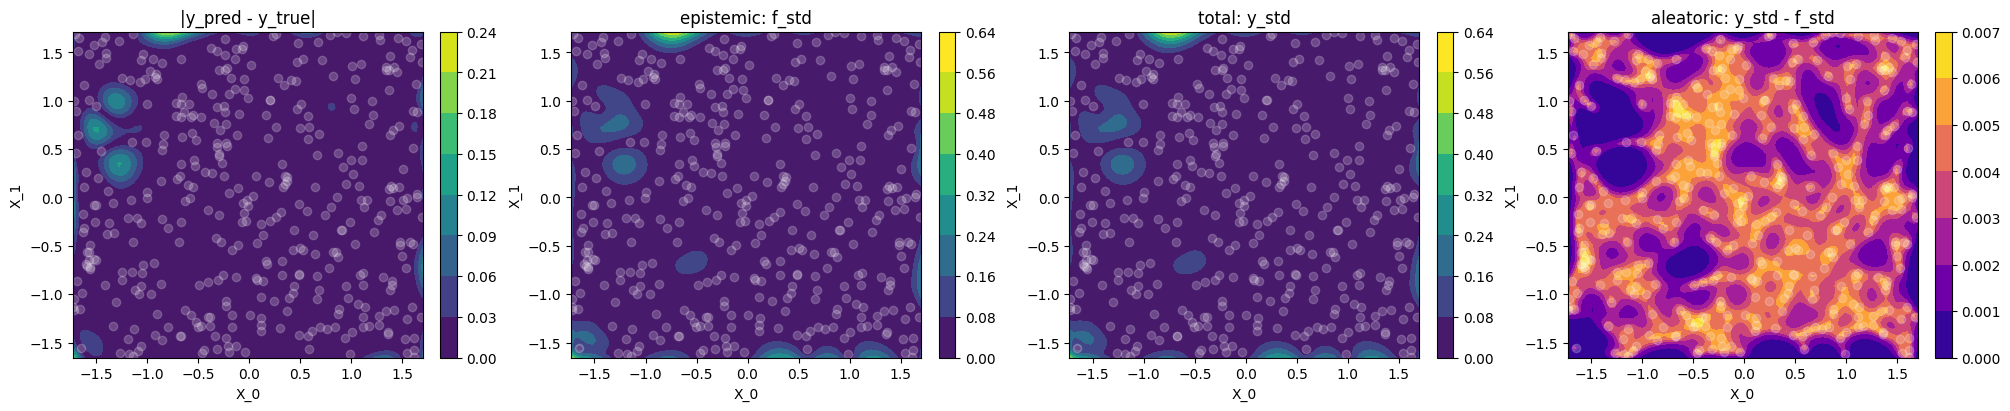

In [22]:
ncols = 4
fig, axs = plt.subplots(
    ncols=ncols, nrows=1, figsize=(ncols * 5, 4), layout="compressed"
)

vmax = post_pred_y.stddev.max()
cs = []

cs.append(
    axs[0].contourf(
        data_pred.XG,
        data_pred.YG,
        torch.abs(post_pred_y.mean - data_pred.z).reshape(
            (data_pred.nx, data_pred.ny)
        ),
    )
)
axs[0].set_title("|y_pred - y_true|")

f_std = post_pred_f.stddev.reshape((data_pred.nx, data_pred.ny))
y_std = post_pred_y.stddev.reshape((data_pred.nx, data_pred.ny))

cs.append(
    axs[1].contourf(
        data_pred.XG,
        data_pred.YG,
        f_std,
        vmin=0,
        vmax=vmax,
    )
)
axs[1].set_title("epistemic: f_std")

cs.append(
    axs[2].contourf(
        data_pred.XG,
        data_pred.YG,
        y_std,
        vmin=0,
        vmax=vmax,
    )
)
axs[2].set_title("total: y_std")

cs.append(
    axs[3].contourf(
        data_pred.XG,
        data_pred.YG,
        y_std - f_std,
        vmin=0,
        cmap="plasma",
        ##vmax=vmax,
    )
)
axs[3].set_title("aleatoric: y_std - f_std")

for ax, c in zip(axs, cs):
    ax.set_xlabel("X_0")
    ax.set_ylabel("X_1")
    ax.scatter(x=X_train[:, 0], y=X_train[:, 1], color="white", alpha=0.2)
    fig.colorbar(c, ax=ax)

## Let's check the learned noise

In [23]:
# Target noise to learn
print("data noise:", noise_std)

# The two below must be the same
print(
    "learned noise:",
    (post_pred_y.stddev**2 - post_pred_f.stddev**2).mean().sqrt().item(),
)
print(
    "learned noise:",
    np.sqrt(
        extract_model_params(model, try_item=True)[
            "likelihood.noise_covar.noise"
        ]
    ),
)

data noise: 0
learned noise: 0.010545823137207347
learned noise: 0.010545823137207347


# Observations

We have the following terms:

* epistemic: `f_std` = $\sqrt{\diag\test{\ma\Sigma}}$
* total: `y_std` = $\sqrt{\diag(\test{\ma\Sigma} + \sigma_n^2\,\ma I_N)}$
* aleatoric: we have two ways of representing it
  * from the likelihood: $\sigma_n$
  * for plotting: we use `y_std` - `f_std`, this is $\neq \sigma_n$ because of the $\sqrt{\cdot}$
    above

We can make the following observations:

* Exercise 1: `use_noise=False`, `use_gap=False`
  * The epistemic uncertainty `f_std` is a good indicator
    of the (small) differences between model prediction and ground truth
  * The learned variance $\sigma_n^2$, and hence the aleatoric uncertainty is
    near zero, which makes sense for noise-free data
* Exercise 2: `use_noise=False`, `use_gap=True`
  * When faced with out-of-distribution (OOD) data, the epistemic `f_std`
    clearly shows where the model will make wrong (less trustworthy)
    predictions
* Exercise 3: `use_noise=True`, `use_gap=True`
  * in-distribution (where we have data)
    * The distinction between
      epistemic and aleatoric uncertainty in the way we define it is less meaningful,
      hence, `f_std` doesn't correlate well with `y_pred - y_true`. The
      reason is that the noise $\sigma_n$ shows up in two parts: (a) in the
      equation of $\test{\ma\Sigma}$ itself, so the "epistemic" uncertainty
      `f_std` = $\sqrt{\diag\test{\ma\Sigma}}$ is bigger just because we have
      noise (regression) and (b) we add it in $\sqrt{\diag(\test{\ma\Sigma} +
      \sigma_n^2\,\ma I_N)}$ to get the total `y_std`
    * The `y_std` plot looks like the `f_std` one, but shifted by a constant.
      But this is not the case because we compare standard deviations and not
      variances, hence `y_std` - `f_std` is not constant, and in particular
      $\neq \sigma_n$, but both are in the same numerical range (0.15 vs. 0.2).
  * out-of-distribution: `f_std` (epistemic) dominates

# Exercises

Go back up, switch on the settings for Exercise 2 and re-run the notebook.
Same with Exercise 3.

# Bonus: plot confidence bands

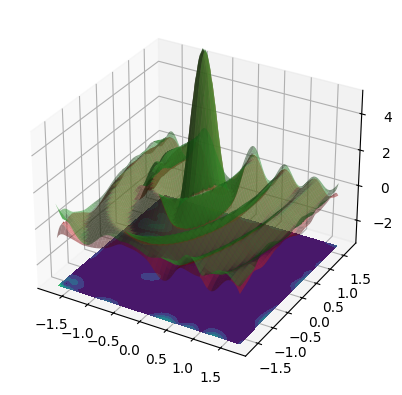

In [24]:
y_mean = post_pred_y.mean.reshape((data_pred.nx, data_pred.ny))
y_std = post_pred_y.stddev.reshape((data_pred.nx, data_pred.ny))
upper = y_mean + 2 * y_std
lower = y_mean - 2 * y_std

fig, ax = fig_ax_3d()
for Z, color in [(upper, "tab:green"), (lower, "tab:red")]:
    ax.plot_surface(
        data_pred.XG,
        data_pred.YG,
        Z,
        color=color,
        alpha=0.5,
    )

contour_z = lower.min() - 1
zlim = ax.get_xlim()
ax.set_zlim((contour_z, zlim[1] + abs(contour_z)))
ax.contourf(data_pred.XG, data_pred.YG, y_std, zdir="z", offset=contour_z)

In [25]:
# When running as script
if not is_interactive():
    plt.show()